# Translation of "Active information sampling varies across the cardiac cycle" by Kunzendorf et al (2019) study from R to Python

## Pre-Processing

Import all needed packages, disable Warning-notifications

In [1]:
import rdata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import scipy.stats as st
from urllib.request import urlopen

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None 

Import needed files from Github 

In [2]:
dataset_url = ("https://github.com/SKunzendorf/0303_INCASI/raw/master/_dataframes/main_exg2_peaks_s_list.RData")
with urlopen(dataset_url) as dataset:
    pars_inc = rdata.parser.parse_file(dataset)
converted_inc = rdata.conversion.convert(pars_inc)
allinc = converted_inc["main_exg2_peaks_s_list"]

pre_fin = ("https://github.com/SKunzendorf/0303_INCASI/raw/master/_dataframes/fin_sys_dur_s.RData")
with urlopen(pre_fin) as dataset:
    pars_fin = rdata.parser.parse_file(dataset)
converted_fin = rdata.conversion.convert(pars_fin)
r_tend = pd.DataFrame.from_dict(converted_fin)

pre_log = ("https://github.com/SKunzendorf/0303_INCASI/raw/master/_dataframes/log_encode.RData")
with urlopen(pre_log) as dataset:
    pars_log = rdata.parser.parse_file(dataset)
converted_log = rdata.conversion.convert(pars_log)
log_enc = converted_log["log_encode"]


pre_bins = ("https://github.com/SKunzendorf/0303_INCASI/raw/master/_dataframes/data_bins.RData")
with urlopen(pre_bins) as dataset:
    pars_bins = rdata.parser.parse_file(dataset)
converted_bins = rdata.conversion.convert(pars_bins)
data_bins = converted_bins["data_bins"]

Define needed variables and empty dataframes for following loops

In [3]:
needed_rows = 0
count = 0
allclicks = pd.DataFrame()
cardiac = pd.DataFrame()
allincs = pd.DataFrame()
rtend_df = pd.DataFrame()

Loop through every participant with eachs R-peaks and button presses to sort them into bins (binary) and find their relative onset (circular)

In [4]:
for key, values in allinc.items():

    singleinc = pd.DataFrame(values, columns=["r_peaks"]) 
   
    # calculate ibi for current person
    ibi = singleinc["r_peaks"].diff() 
    ibi = ibi.shift(-1)
    singleinc["ibi"] = ibi
    
    rtend = r_tend["sys_dur_s"].iloc[count] 
    qonR = log_enc["qonR"].iloc[needed_rows]
    peplength = log_enc["pep"].iloc[needed_rows]
    crop = data_bins[data_bins.vp == key].crop.values
    qt = qonR + rtend # get complete length of systole (q to t wave)
    singleinc["qwave"] = singleinc["r_peaks"] - qonR
    ep = float(qt - peplength)
    singleinc["sys_end"] = singleinc.r_peaks + rtend
    click = pd.DataFrame(log_enc["click1onset_ecgtime_s"][needed_rows: needed_rows +120])
    click.columns = ["clicks"]
  
    needed_rows = needed_rows + 120

    #create cardiac phase bins
    pep = []
    sys = []
    xtime = []
    dias = []

    # loop through button presses and sort them into bins (binary)
    for index, row in singleinc.iterrows():
        qwave = row["qwave"]
        r = row["r_peaks"]
        sys_end = row["sys_end"]
        xlen = 0.05
        next_q = singleinc.loc[index + 1, "qwave"] if index + 1 < len(singleinc) else float("inf") 
        
        pepclick = click.loc[(click["clicks"] >= qwave) & (click["clicks"] <= (qwave + peplength))]
        syst = click.loc[(click["clicks"] > (qwave + peplength)) & (click["clicks"] <= sys_end)] # sorts into systole if click between r peak and systole-end (twave end)
        xperiod = click.loc[(click["clicks"] > sys_end) & (click["clicks"] <= (sys_end + xlen))]
        diast = click.loc[(click["clicks"] > (sys_end + xlen)) & (click["clicks"] < next_q)] # sorts into diastole if click between systole end and next r peak
        pep.extend(pepclick["clicks"].tolist()) # appending binned values to list 
        sys.extend(syst["clicks"].tolist()) # appending binned values to list 
        xtime.extend(xperiod["clicks"].tolist()) # appending binned values to list 
        dias.extend(diast["clicks"].tolist())   

    pep_df = pd.DataFrame({"clicks": pep}) 
    sys_df = pd.DataFrame({"clicks": sys}) 
    x_df = pd.DataFrame({"clicks": xtime}) 
    dias_df = pd.DataFrame({"clicks": dias})
    pep_clicks = len(pep_df)
    sys_clicks =len(sys_df)
    x_clicks = len(x_df)
    dias_clicks = len(dias_df)

    # circular transformation of button press onsets
    for index, row in click.iterrows():
        diff = row["clicks"] - singleinc.r_peaks 
        diff = diff [diff > 0]
        clos_r_idx = diff.idxmin()
        click.loc[index, "clos_r"] = singleinc.r_peaks[clos_r_idx]
        click.loc[index, "clos_ibi"] = singleinc.ibi[clos_r_idx]
        click.loc[index, "rel"] = diff[clos_r_idx]

    click_circ =[]
    for index, row in click.iterrows():
        res = row["rel"] * 2 * np.pi  * (1 / row["clos_ibi"]) 
        click_circ.append(res)
    click["circ"] = click_circ
    
    rr = click.clos_ibi.mean()
    diaslength = rr - qt - 0.050
    sysrel = (sys_clicks / 120) / (ep / rr) # syspat is length of sys
    diasrel = (dias_clicks / 120) / ( diaslength / rr) # if rel > 1 higher probability to click during this phase
    
    # calculate circular mean for each participant
    circ_mean = st.circmean(click_circ)
    if circ_mean < 0:
        circ_mean = circ_mean + 2 * np.pi

    # append values to dataframes
    magn = np.sqrt((np.square(np.sum(np.sin(click_circ)))) + (np.square(np.sum(np.cos(click_circ)))))
    temp = pd.DataFrame({"inc": key, "sys": sys_clicks, "dias": dias_clicks, "ibi": rr, "pep": pep_clicks, "x": x_clicks, "sysrel": sysrel, "diasrel": diasrel, "pep_len": peplength, "crop_len": crop, "dias_len": diaslength, "qonR" : qonR, "circ_mean": circ_mean, "magnitude": magn})
    allclicks = pd.concat([allclicks, temp], ignore_index = True)
    singleinc["inc"] = key
    click["inc"] = key
    rtend_new = pd.DataFrame({'inc': [key], 'sys_dur': [rtend]})
    rtend_df = pd.concat([rtend_df, rtend_new])
    allincs = pd.concat([allincs, click], ignore_index = True)
    cardiac = pd.concat([cardiac, singleinc], ignore_index = True)
    count = count + 1


Save created data frames as csv files for further analyses to save time when restarting the programm

In [49]:
cardiac.to_csv("_dataframes/_dataframes_csv/cardiac.csv", index = False)
allincs.to_csv("_dataframes/_dataframes_csv/allincs.csv", index = False)
rtend_df.to_csv("_dataframes/_dataframes_csv/rtend.csv", index = False)
allclicks.to_csv("_dataframes/_dataframes_csv/allclicks.csv", index = False)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Statistical Testing 


Load csv files from above

In [2]:
cardiac = pd.read_csv("_dataframes/_dataframes_csv/cardiac.csv")
allincs = pd.read_csv("_dataframes/_dataframes_csv/allincs.csv")
r_tend = pd.read_csv("_dataframes/_dataframes_csv/rtend.csv")
allclicks = pd.read_csv("_dataframes/_dataframes_csv/allclicks.csv")

Input participants you want to look at (if none are inserted in "excluded" the analysis looks at all participants) <br>
Participant inc11, inc40, inc41 are excluded because of high bloodpressure and a high heartrate

In [3]:
included = [] 
excluded = [11, 40, 41] 

Filtering out the data for the above chosen participants

In [4]:
if included:
    included = [f"inc{p:02}" for p in included]
if excluded:
    excluded = [f"inc{p:02}" for p in excluded]

if included:
    spec_incs = allincs[allincs["inc"].isin(included)]
    spec_cardiac = cardiac[cardiac["inc"].isin(included)]
    spec_clicks = allclicks[allclicks["inc"].isin(included)]
    spec_rtend = r_tend[r_tend["inc"].isin(included)]

elif excluded:
    spec_incs = allincs[~allincs["inc"].isin(excluded)]
    spec_cardiac = cardiac[~cardiac["inc"].isin(excluded)]    
    spec_clicks = allclicks[~allclicks["inc"].isin(excluded)]
    spec_rtend = r_tend[~r_tend["inc"].isin(excluded)]

else:
    spec_incs = allincs
    spec_cardiac = cardiac
    spec_clicks = allclicks
    spec_rtend = rtend

Testing mean, standard deviation and standard error of systolic and diastolic ratios

In [5]:
print("Mean of all systolic ratios: ", "\t", "\t", "\t", round(spec_clicks["sysrel"].mean(),3))
print("Mean of all diastolic ratios: ","\t", "\t", "\t", round(spec_clicks["diasrel"].mean(),3))
print("Standard-derivation of all systolic ratios: ", "\t", round(np.std(spec_clicks["sysrel"]),3))
print("Standard-derivation of all diastolic ratios: ","\t", round(np.std(spec_clicks["diasrel"]),3))
print("Standard error of systolic ratio: ", "\t", "\t", round(st.sem(spec_clicks.sysrel),3))
print("Standard error of diastolic ratio: ", "\t", "\t", round(st.sem(spec_clicks.diasrel),3))

Mean of all systolic ratios:  	 	 	 1.055
Mean of all diastolic ratios:  	 	 	 0.971
Standard-derivation of all systolic ratios:  	 0.139
Standard-derivation of all diastolic ratios:  	 0.08
Standard error of systolic ratio:  	 	 0.021
Standard error of diastolic ratio:  	 	 0.012


Testing correlation between systolic and diastolic ratio

In [6]:
print(st.ttest_rel(spec_clicks.sysrel, spec_clicks.diasrel))
print(st.wilcoxon(spec_clicks.sysrel, spec_clicks.diasrel))
def cohens (x,y):
    mean_diff = np.mean(x-y)
    pooled_sd = np.std(y-x)
    cohens_d = mean_diff / pooled_sd
    return cohens_d

print("Cohens d: ", "\t", round(cohens(spec_clicks.sysrel, spec_clicks.diasrel),3))

TtestResult(statistic=2.7600175322533467, pvalue=0.008529451826475656, df=42)
WilcoxonResult(statistic=263.0, pvalue=0.01040263543995934)
Cohens d:  	 0.426


Testing if systolic and diastolic ratio are normally distributed

In [7]:
print(st.shapiro(spec_clicks.sysrel))
print(st.shapiro(spec_clicks.diasrel))

ShapiroResult(statistic=0.9817510648822774, pvalue=0.7164323077076338)
ShapiroResult(statistic=0.9758061429706271, pvalue=0.49052854783646027)


Computing circular mean and its standard deviation of all participants

In [8]:
print("circular mean of all participants circular means: ", "\t", "\t", round(st.circmean(spec_clicks["circ_mean"])/np.pi, 3))
print("standard derivation of all participants circular means: ", "\t", round(st.circstd(spec_clicks["circ_mean"])/np.pi, 3))   

circular mean of all participants circular means:  	 	 0.328
standard derivation of all participants circular means:  	 0.522


--------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Plotting Results

### Defining plotting function for circular plots

In [10]:
def circ_plot():
    ax.set_theta_direction(-1)  # set direction clockwise
    ax.set_theta_zero_location("N")  # zero at the top
    ax.set_yticklabels([]) 
    ax.set_yticks([]) 
    ax.set_xticks(np.linspace(0, 2 * np.pi, 5 ))  
    ax.set_xticklabels(["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", ""], fontsize = 14)  # label ticks
    ax.spines["polar"].set_visible(False)
    ax.grid(False)

### Histogram with distribution of systolic and diastolic ratios of all participants

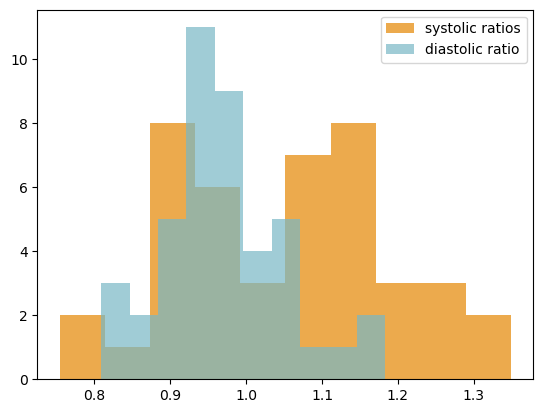

In [11]:
fig, ax = plt.subplots()
ax.hist(spec_clicks.sysrel, alpha=0.7, label ="systolic ratios", color = "#E58601", bins= 10)
ax.hist(spec_clicks.diasrel, alpha=0.7, label = "diastolic ratio", color = "#78B7C5", bins= 10)
ax.legend(loc="upper right") 
#plt.title("Distribution of Systolic and Diastolic Ratios") 
plt.savefig("_figures/_figures_translation/histo_distribution_of_ratios.png", dpi=350) 
plt.show()

### Histogram of all clicks from all participants sorted into systole, x-period, diastole, pep

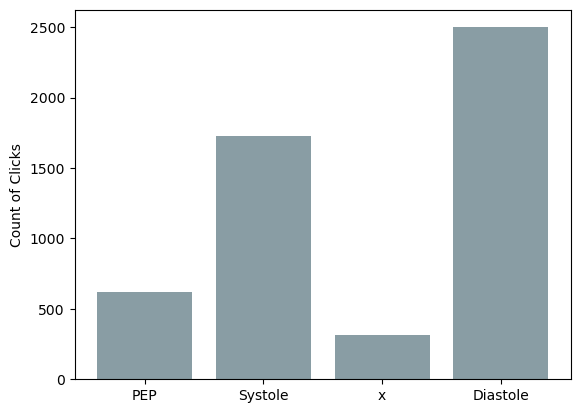

In [12]:
fig, ax = plt.subplots()
ax.bar(["PEP","Systole", "x", "Diastole"],[spec_clicks.pep.sum(), spec_clicks.sys.sum(), spec_clicks.x.sum(), spec_clicks.dias.sum()], color = "#899DA4")
plt.ylabel("Count of Clicks")
#plt.title("Distribution of 120 Clicks within the Cardiac Cycle")
plt.savefig("_figures/_figures_translation/distribution_of_clicks.png", dpi=350) 
plt.show()

### Binary scatter plot <br>
creating a scatter-plot with one point being one participant with their systolic and diastolic ratio

defining limits for the quadrants

In [13]:
small_sys = spec_clicks.sysrel < 1
big_sys = spec_clicks.sysrel > 1
small_dias = spec_clicks.diasrel < 1
big_dias = spec_clicks.diasrel > 1
sys_mean = spec_clicks["sysrel"].mean()
dias_mean = spec_clicks["diasrel"].mean()

Plotting the ratios: systolic quadrant (orange), diastolic quadrant (blue), undefinded (grey)

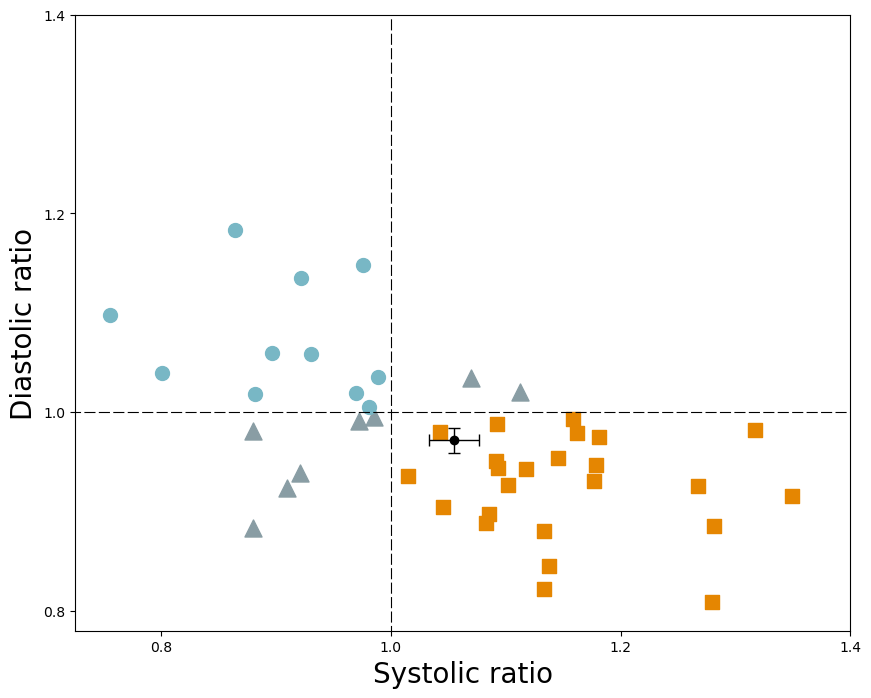

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.axline((1, 0.8), (1, 1.2 ), linewidth = 0.8, linestyle = (5, (10, 3)), color = "black" )
ax.axline((0.8, 1), (1.2, 1), linewidth = 0.8, linestyle = (5, (10, 3)), color = "black")
ax.scatter(spec_clicks[(small_sys) & (small_dias)].sysrel, spec_clicks[(small_sys) & (small_dias)].diasrel, color="#899DA4", marker="^", s = 150)
ax.scatter(spec_clicks[(small_sys) & (big_dias)].sysrel, spec_clicks[(small_sys) & (big_dias)].diasrel, color="#78B7C5", s = 100)
ax.scatter(spec_clicks[(big_sys) & (small_dias)].sysrel, spec_clicks[(big_sys) & (small_dias)].diasrel, color="#E58601",marker= "s", s = 100)
ax.scatter(spec_clicks[(big_sys) & (big_dias)].sysrel, spec_clicks[(big_sys) & (big_dias)].diasrel, color="#899DA4", marker="^", s = 150)
plt.errorbar( sys_mean, dias_mean, xerr = st.sem(spec_clicks.sysrel), yerr= st.sem(spec_clicks.diasrel),fmt='o', color = "black", elinewidth=1, capsize=4)
plt.xlabel("Systolic ratio", fontsize= 20 )
plt.ylabel("Diastolic ratio", fontsize = 20)
plt.xticks([0.8, 1.0, 1.2, 1.4])
plt.yticks([0.8, 1.0, 1.2, 1.4])
plt.rcParams["figure.figsize"]= [4.5,4.5]
#plt.title("Systolic and Diastolic Ratios of all Participants") 
plt.savefig("_figures/_figures_translation/binary_scatterplot.png", dpi=350) 
plt.show()

### Circular plot of single participant

Insert chosen participant for first level analysis

In [15]:
inc = 25

Defining variables adjusted to the chosen participant

In [16]:
inc = f"inc{inc:02}"
circ_trans = 2 * np.pi * (1/ allclicks[allclicks["inc"] == inc].ibi.iloc[0])
sys_start = allclicks[allclicks["inc"] == inc].crop_len.iloc[0] * circ_trans
sys_end = r_tend[r_tend["inc"] == inc].sys_dur.iloc[0] * circ_trans
dias_start = sys_end + (0.05  * circ_trans)
dias_end = dias_start + (allclicks[allclicks["inc"] == inc].dias_len.iloc[0] * circ_trans)

circ_clicks = allincs[allincs["inc"] == inc].circ.sort_values()
mean = allclicks[allclicks["inc"] == inc].circ_mean.iloc[0]
magn = allclicks[allclicks["inc"] == inc].magnitude.iloc[0]/len(circ_clicks)

Defining parameters for the circular density visualization

In [17]:
mu = st.circmean(circ_clicks)
sin_sum = np.sum(np.sin(circ_clicks))
cos_sum = np.sum(np.cos(circ_clicks))

two_circ_clicks = pd.concat([circ_clicks[circ_clicks > np.pi] - 2*np.pi, circ_clicks, circ_clicks[circ_clicks < np.pi] + 2*np.pi], ignore_index=True)
kernel = st.gaussian_kde(two_circ_clicks, bw_method=0.037)
density= kernel.pdf(two_circ_clicks)
ran = len(two_circ_clicks[two_circ_clicks < 0])

r = np.full_like(np.linspace(0, 2*np.pi, 100), 1 )

Plotting the distribution of participants 120 clicks across the cycle with Phase lengths starting with colored line (systole: orange; diastole: blue) and ending with a dashed one; <br>
The circular density is shown as a grey line around the circle

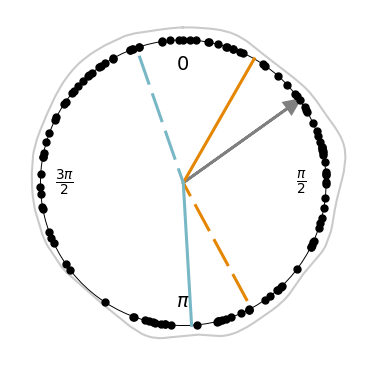

In [18]:
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.plot(np.linspace(0, 2*np.pi, 100), r , color = "black", label = "Density-Minimum", linewidth = 0.7)
ax.plot(two_circ_clicks[ran-1:ran+120], density[ran-1:ran+120] + 1, color="#969696", alpha = 0.5, label="Von Mises Density")
ax.plot([sys_start,sys_start], [0,1], color = "#E58601", label = "Systole Start" , linewidth = 2.2)
ax.plot([sys_end,sys_end], [0,1], color = "#E58601", label = "Systole End", linewidth = 2.2, linestyle = (5, (10, 3)))
ax.plot([dias_start,dias_start], [0,1], color = "#78B7C5", label = "Diastole Start" , linewidth = 2.2)
ax.plot([dias_end,dias_end], [0,1], color = "#78B7C5", label = "Diastole End", linewidth = 2.2, linestyle = (5, (10, 3)))
ax.scatter(circ_clicks, np.ones(120), s = 25, color = "black", zorder = 2)
ax.arrow(mean, 0, 0, 0.9, color="gray", head_width=0.1, head_length=0.1, lw= 2)
ax.tick_params(axis="x", pad=-50) 
circ_plot()
#plt.title("Circular Click Distribution " + inc) 
#plt.legend(loc = "upper left")
plt.savefig("_figures/_figures_translation/circular_inc25.png", dpi=350) 
plt.show()

In [19]:
print("Circular button press Mean for chose participant: ", "\t", round(mean/np.pi, 3))
print("Mean Resultant Length of Mean above: " ,"\t" ,"\t", "\t", round(magn,3))

Circular button press Mean for chose participant:  	 0.303
Mean Resultant Length of Mean above:  	 	 	 0.146


### Circular histogram showing all clicks of all participants over the cardiac cycle

Insert number of bins wanted for the histogram

In [20]:
bin_num = 30 

Defining needed variables for coloring and sorting

In [21]:
data = spec_incs["circ"]
r_tend_mean = spec_rtend.sys_dur.mean() * 2 * np.pi
r_tend_std = spec_rtend.sys_dur.std() * 2 * np.pi
systole = data[data < r_tend_mean]
diastole = data[data > r_tend_mean]
binsize = round(r_tend_mean / (2 * np.pi) * bin_num)

Plotting the histogram with systole (orange) and diastole (blue) parted by the mean systolic onset of all participants

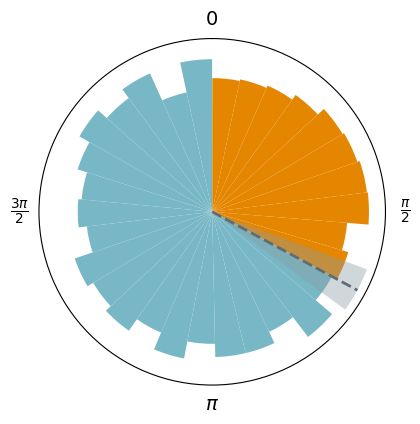

In [22]:
ax = plt.subplot(projection="polar")
ax.hist(systole, bins=binsize, color="#E58601")
ax.hist(diastole, bins=(bin_num - binsize), color="#78B7C5")
ax.plot([r_tend_mean, r_tend_mean], [0, 200], color="#5f6d72", linestyle="--", linewidth=2, label = "mean of all r-tend-intervalls")  
ax.bar(x = r_tend_mean, height= 200, width = r_tend_std * 2, color = "#899DA4",alpha = 0.4)
circ_plot()
ax.spines["polar"].set_visible(True)

#ax.set_title("Circular Histogramm of Clicks from all Participants")
plt.savefig("_figures/_figures_translation/circular_histo_all.png", dpi=350) 
plt.show()

In [23]:
print("Mean of systolic onsets from all participants: ","\t" ,r_tend_mean/np.pi)
print("Standard deviation of above mean: ", "\t" ,"\t", "\t" ,r_tend_std/np.pi)

Mean of systolic onsets from all participants:  	 0.6575899345930233
Standard deviation of above mean:  	 	 	 0.04430297535614479


### Circular plot of circular means from all incs <br>
Plot showing the circular mean of each participant as a dot as well as the overall circular density

Defining different parts and phases of the cardiac cycle

In [24]:
circ_means = spec_clicks["circ_mean"].sort_values()

ibi_circ = []
for ibi in spec_clicks["ibi"]:
    ibi_trans = (2 * np.pi) / ibi 
    ibi_circ.append(ibi_trans)
spec_clicks["ibi_circ"] = ibi_circ 

circ_trans_all = np.mean(spec_clicks["ibi_circ"])

crop_circ = []
for crop in spec_clicks["crop_len"]:
    crop_trans = circ_trans_all * crop
    crop_circ.append(crop_trans)
spec_clicks["crop_circ"] = crop_circ 

rt_circ = []
for rt in spec_rtend["sys_dur"]:
    rt_trans = circ_trans_all * rt
    rt_circ.append(rt_trans)
spec_rtend["rt_circ"] = rt_circ 

dias_circ = []
for dias in spec_clicks["dias_len"]:
    dias_trans = circ_trans_all * dias
    dias_circ.append(dias_trans)
spec_clicks["dias_circ"] = dias_circ 

sys_start_all = np.mean(spec_clicks["crop_circ"])
sys_end_all = np.mean(spec_rtend["rt_circ"])
dias_start_all = np.mean(sys_end_all + (0.05 * circ_trans_all))
dias_end_all = np.mean(dias_start_all + dias_circ)

Computing the circular density

In [25]:
circ_means = circ_means.sort_values()
sin_sum_spec = np.sum(np.sin(circ_means))
cos_sum_spec = np.sum(np.cos(circ_means))
mu_spec = st.circmean(circ_means)
spec_magn = np.sqrt(np.square(sin_sum_spec) + (np.square(cos_sum_spec))) / len(circ_means)

two_circ_means = pd.concat([circ_means[circ_means > np.pi] - 2*np.pi, circ_means, circ_means[circ_means < np.pi] + 2*np.pi], ignore_index=True)
all_kernel = st.gaussian_kde(two_circ_means, bw_method=.1)
all_density= all_kernel.pdf(two_circ_means)
ran_all = len(two_circ_means[two_circ_means < 0])
r = np.full_like(np.linspace(0, 2*np.pi, 100), 1 )

Adjust bootstrapping number (nBoot) to needs (higher numbers lead to increased processing time)

In [26]:
vplist = list(spec_rtend["inc"])  
out = []
bwparam = 9
nBoot = 500 

for i in range(nBoot):  
    vplist_boot = np.random.choice(vplist, size=len(vplist), replace=True) 
    buffer = []

    for j in range(len(vplist_boot)):  
        x = spec_incs[spec_incs["inc"] == vplist_boot[j]].circ 
        two_x = pd.concat([x[x > np.pi] - 2 * np.pi, x, x[x < np.pi] + 2 * np.pi], ignore_index=True)

        kde = st.gaussian_kde(two_x, bw_method=bwparam/len(x))
        theta = np.linspace(0, 2 * np.pi, 2000)  
        density = kde(theta)

        buffer.append(density)
    buffer = np.mean(buffer, axis=0)
    out.append(buffer)

out = np.array(out)

ci_median = np.median(out, axis=0)
ci_median_normalized = ci_median / np.max(ci_median)

In [28]:
# Calculate the 95% confidence intervals and median
ci_lower = np.percentile(out, 2.5, axis=0)
ci_upper = np.percentile(out, 97.5, axis=0)
ci_median = np.percentile(out, 50, axis=0)

# Normalize the density for circular plot
ci_median_normalized = ci_median / np.max(ci_upper)  # Normalize to the upper bound
ci_lower_normalized = ci_lower / np.max(ci_upper)
ci_upper_normalized = ci_upper / np.max(ci_upper)

scale_factor = 12.5 # Adjust this factor to fit the density within the plot
ci_median_scaled = ci_median * scale_factor
ci_lower_scaled = ci_lower * scale_factor
ci_upper_scaled = ci_upper * scale_factor

Plotting means and density (grey), coloration as in circular plot for single participant

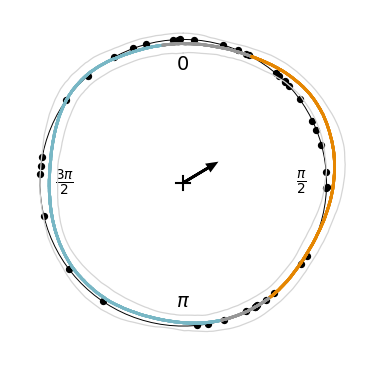

In [35]:
head_len = 0.05
ax = plt.subplot(projection="polar")
ax.plot(np.linspace(0, 2* np.pi, 100), r , linewidth= 0.7, color = "black", label = "Density-Minimum")
ax.scatter(circ_means, np.ones_like(circ_means), s = 18, color = "black", zorder = 2)
for i in range(len(theta) - 1):
    if sys_start_all <= theta[i] <= sys_end_all:
        color = "#E58601"
    elif dias_start_all <= theta[i] <= dias_end_all:
        color = "#78B7C5"
    else:
        color = "#969696"
    ax.plot(theta[i:i + 2], ci_median_scaled[i:i + 2], color=color, linewidth=2)

ax.plot(theta, ci_upper_scaled, color= "#d5d5d5", linewidth = 0.9)
ax.plot(theta, ci_lower_scaled, color="#d5d5d5",  zorder = 2, linewidth = 0.9)
ax.arrow(mu_spec, 0, 0, spec_magn-head_len, color="black", head_width=0.2, head_length=head_len, lw=2)
ax.plot([np.pi/2, 3 *np.pi/2], [ 0.05, 0.05], color = "black")
ax.plot([np.pi, 0], [0.05,0.05], color = "black")
circ_plot() # label ticks
ax.spines['polar'].set_visible(False)
ax.tick_params(axis="x", pad=-50)  
#ax.set_title("Circular Histogramm of Circular Means of all Participants")
plt.savefig("_figures/_figures_translation/circ_means.png", dpi=350) 
plt.show()

In [114]:
print("Circular button press Mean for all circular means: ", "\t", round(mu_spec/np.pi,3))
print("Mean Resultant Length of Mean above: " ,"\t" ,"\t", "\t", round(spec_magn,3))

Circular button press Mean for all circular means:  	 0.328
Mean Resultant Length of Mean above:  	 	 	 0.261
